# 1D model for simulating seed dispersal 

This Jupyter Notebook contains the code used to model the dispersal of *Impatiens glandulifera* seeds in 1D based of various interacting factors including seed traits, discharge, stage and suspended sediment concentration. 

In [1]:
# Python packages used:
import numpy as np # (Harris et al., 2024)
import matplotlib.pyplot as plt # # (Hunter, 2007)
import pandas as pd # (The pandas development team, 2020)


## Setting model parameters

In [11]:
# Minimum and maximum seed trait range   (Gaussian for density and diameter)
seed_density_min = 400  # Minimum seed density (g/cm³)
seed_density_max = 1200  # Maximum seed density (g/cm³)
seed_diameter_min = 900 # Minimum seed diameter (mm)
seed_diameter_max = 1800  # Maximum seed diameter (mm)

# Calculate means for Gaussian distributions
mean_seed_density = (seed_density_max + seed_density_min)/2
mean_seed_diameter = (seed_diameter_max + seed_diameter_min)/2

# Standard deviation estimation (using range-based rule, 99.7% of data lies within min/max)
std_seed_density = (seed_density_max - seed_density_min) / 6  # 99.7% of data in the range
std_seed_diameter = (seed_diameter_max - seed_diameter_min) / 6  # 99.7% of data in the range

# Number of seeds for the simulation
# stand_area = 1170 # area of Impateins glandluifera stand (m2)
#seed_rain = 6000 # seed rain reported by Beerling DJ & Perrins JM (1993) (seed/m2) 

#num_seed = stand_area * seed_rain

num_seeds = 1500 # total number of seeds to be simulated

# Generate seed densities using normal distribution and clip to the desired range
seed_densities = np.random.normal(loc=mean_seed_density, scale=std_seed_density, size=num_seeds)
seed_densities = np.clip(seed_densities, seed_density_min, seed_density_max)  # Clip values to stay within range

# Generate seed diameters using normal distribution and clip to the desired range
seed_diameters = np.random.normal(loc=mean_seed_diameter, scale=std_seed_diameter, size=num_seeds)
seed_diameters = np.clip(seed_diameters, seed_diameter_min, seed_diameter_max)  # Clip values to stay within range

# convert seed densities to kg/m3
seed_densities_kgm3 = seed_densities * 1000
# Convert seed diameter to meters
seed_diameters_m = seed_diameters/100  # Convert to meters for calculations


# Constants for seed behavior and hydraulic parameters
C1 = 100  # Empirical constant 1 - determined through interaction with observed data 
C2 = 25  # Empirical constant 2 - determined through interaction with observed data 
g = 9.81  # Gravitational acceleration (m/s²) 
nu = 1.0e-6  # Kinematic viscosity of water (m²/s), assumed for freshwater

base_flow_velocity = 0.51  # Base flow velocity [m/s]
manning_n_channel = 0.035  # Roughness for the channel
manning_n_floodplain = 0.08  # Roughness for the floodplain
ssc_effect_factor_velocity = 0.1  # How suspended sediment load affects seed velocity
channel_slope = 0.0015 # channel slope estimated from google earth pro

## Seed: standardising units and calculating settling velocity 
# Convert seed density to SI units (density: kg/m³ & length: m)
seed_densities_kgm3 = seed_densities * 1000  # Convert to kg/m³
seed_diameters_m = seed_diameters_m  # Seed diameters are already in meters
R =seed_densities_kgm3/1000

# Calculate initial settling velocities (m/s) using Ferguson and Church (2004) formula for each seed
settling_velocities = (R * g * seed_diameters_m**2) / (C1 * nu + (0.75 * C2 * R * g * seed_diameters_m**3)**0.5)
settling_velocities_per_day = settling_velocities * 86400  # Convert m/s to m/day

In [16]:
## load hydrology timeseries data 
hydrograph_file = 'Elland_Q.csv' # Discharge (m³/s)
water_level_file = 'Elland_L.csv'  # Level (m)

hydrograph_df = pd.read_csv(hydrograph_file)
water_level_df = pd.read_csv(water_level_file)

# Extract values as numpy arrays
hydrograph = hydrograph_df.iloc[:, 0].values  # Discharge values
water_levels = water_level_df.iloc[:, 0].values  # Water levels

## setting time step 
time_steps = len(hydrograph)  # Number of time steps from the hydrograph (daily) 

## determing the effect of water level on seeds 
# Define above bankfull water level (m) threshold to delineate overbank flow
threshold_water_level = 1.35 # specify known overbank flow water level threshold

# Threshold for seed deposition above threshold
deposition_threshold = 0.50  # **Arbitrary** no good field data for this - maybe ask Zarah with mats? 


In [17]:
# Setting up variables for data to be stored from the model 
dispersal_distances = []  # Stores average dispersal distances over time
seed_positions_over_time = []  # Stores positions of all seeds at each time step
seed_velocities_over_time = []  # Stores velocities at each time step
deposited_seeds_over_time = []  # Track number of deposited seeds
total_distance_traveled = []  # Total distance traveled by all seeds
active_seeds_over_time = []  # Number of active (non-deposited) seeds

In [18]:
# Initial seed positions and distances
seed_positions = np.zeros(num_seeds)  # All seeds start at the origin (position 0)
seed_distances = np.zeros(num_seeds)  # Distance traveled by each seed

# Simulation loop
for t in range(time_steps):
    # Get current discharge and water level for this day
    current_discharge = hydrograph[t]
    current_water_level = water_levels[t] 
    
    # Calculate suspended sediment load using the given formula
    current_ssc = 0.0002 * current_discharge**2 + 0.0586 * current_discharge - 0.951 # based of CAESAR-Lisflood output data 
    current_ssc = max(current_ssc, 0) 

    # Determine if the current water level is in the channel or floodplain
    if current_water_level < threshold_water_level:
        # Seed is in the channel
        n = manning_n_channel 
    else:
        # Seed is in the floodplain
        n = manning_n_floodplain
    
    # Apply Manning's n roughness equation to adjust velocity based on hydrograph and water level
    adjusted_velocity = (1 / n) * (base_flow_velocity ** (2/3)) * (channel_slope ** (1/2)) * current_discharge  
    
    # Incorporate suspended sediment load effects on velocity
    adjusted_velocity *= (1 - ssc_effect_factor_velocity * current_ssc)  # Reducing velocity based on SSC
    
    # Convert to a positive velocity (if negative, don't let it move upstream)
    adjusted_velocity = max(adjusted_velocity, 0)  # seeds are not permitted to be moved upstream assumed downstream transport 
    
    # Collect seed positions and velocities for this timestep
    seed_positions_over_time.append(seed_positions.copy())  # Store positions
    seed_velocities_over_time.append(np.full(num_seeds, adjusted_velocity))  # Store velocities for each seed

    # Track number of deposited seeds
    deposited_seeds_over_time.append(np.sum(seed_positions == -1))
    
    # Calculate total distance traveled by all seeds, excluding deposited seeds
    total_distance_traveled.append(np.sum(seed_distances[seed_positions != -1]))
    
    # Count number of active seeds (seeds that are still moving)
    active_seeds_over_time.append(np.sum(seed_positions != -1))

    # Move seeds
    for i in range(num_seeds):
        x = seed_positions[i]  # Get the current position of the seed

        # Determine seed location (channel or floodplain)
        if current_water_level < threshold_water_level:  
            # Seed is in the channel
            seed_positions[i] = max(0, min(1000, x + adjusted_velocity))  # Move downstream in channel
        else:  # Floodplain
            # If seed is in the floodplain, it has a chance of being deposited
            if np.random.rand() < deposition_threshold:
                seed_positions[i] = -1  # Mark seed as abandoned (deposited)
            else:
                # Seed moves slower in the floodplain, affected by Manning's roughness
                seed_positions[i] = max(0, min(1000, x + adjusted_velocity * 0.5))  # Slower in floodplain
        
        # Update distance traveled
        seed_distances[i] += abs(adjusted_velocity)

        # Deposition condition: Seed deposits when its velocity is very small or if it has traveled a distance
        if adjusted_velocity < 0.4: # velocity theshold for deposition estimated based on Hjulström curve
            seed_positions[i] = -1  # Mark as deposited (no further movement)
        
        # If seed has already deposited, it doesn't move anymore
        if seed_positions[i] == -1:
            continue

    # Calculate the average dispersal distance, excluding deposited seeds
    active_seed_distances = seed_distances[seed_positions != -1]
    if active_seed_distances.size > 0:
        avg_distance = np.mean(active_seed_distances)  # Ignore deposited seeds
    else:
        avg_distance = 0  # In case all seeds have deposited
    dispersal_distances.append(avg_distance)

mean_dispersal_distance = np.mean(dispersal_distances)
print(f"Mean Dispersal Distance: {mean_dispersal_distance:.2f} meters")

max_dispersal_distance = np.max(dispersal_distances)
print(f"Max Dispersal Distance: {max_dispersal_distance:.2f} meters")

Mean Dispersal Distance: 970.37 meters
Max Dispersal Distance: 1953.70 meters


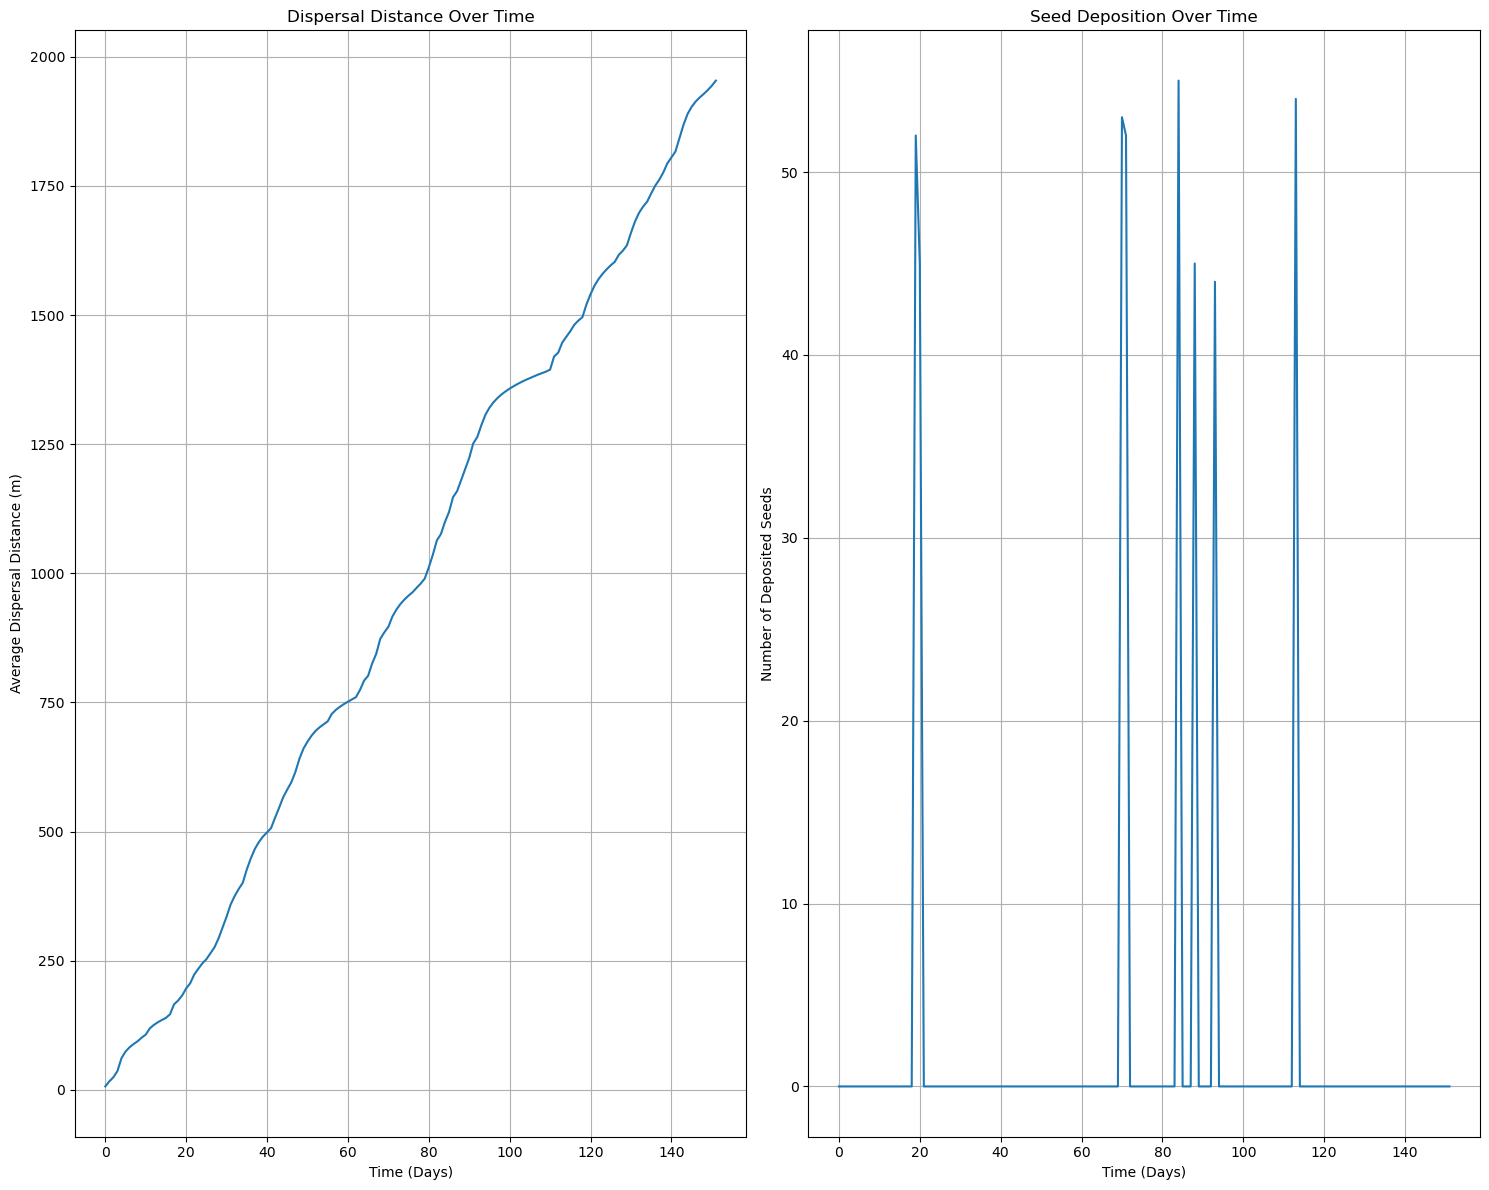

<Figure size 1000x600 with 0 Axes>

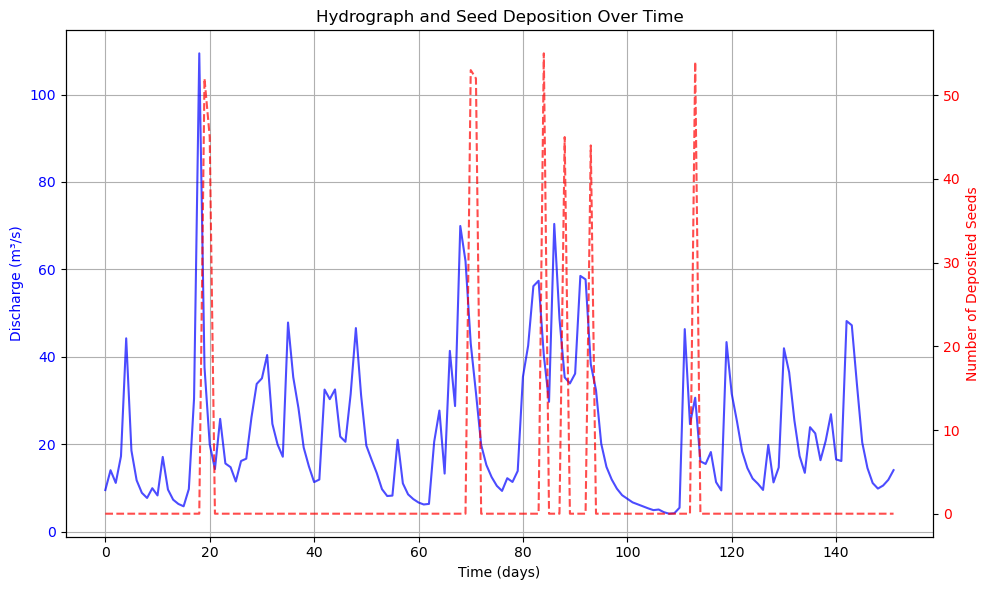

<Figure size 1000x600 with 0 Axes>

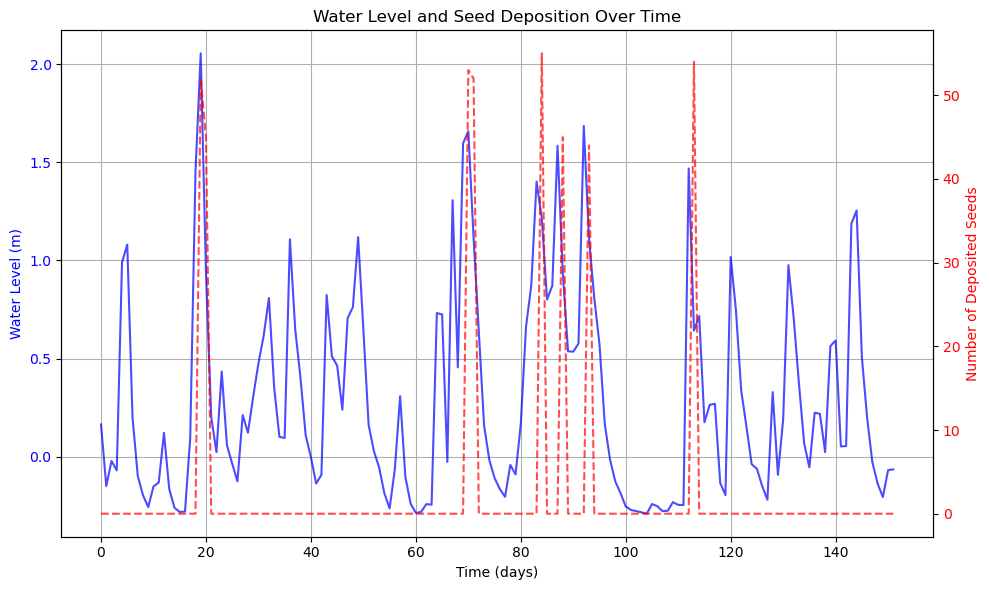

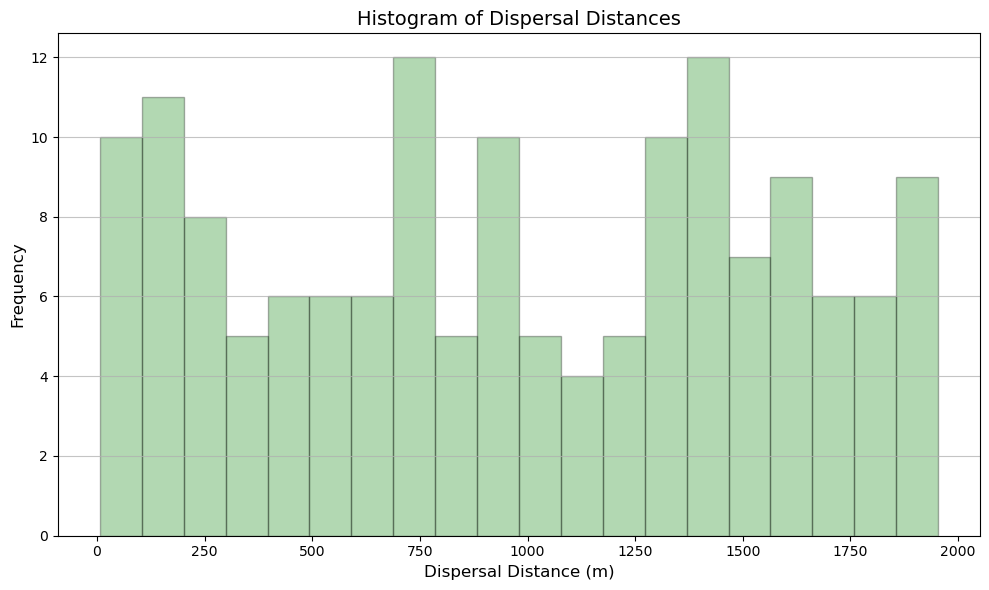

In [11]:
# plotting 
interval = 20
grouped_dispersal_distances = [dispersal_distances[i:i+interval] for i in range(0, len(dispersal_distances), interval)]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 12))

# Plot dispersal distance over time
axes[0].plot(dispersal_distances)
axes[0].set_title('Dispersal Distance Over Time')
axes[0].set_xlabel('Time (Days)')
axes[0].set_ylabel('Average Dispersal Distance (m)')
axes[0].grid(True)


# Plot seed deposition over time
axes[1].plot(deposited_seeds_over_time)
axes[1].set_title('Seed Deposition Over Time')
axes[1].set_xlabel('Time (Days)')
axes[1].set_ylabel('Number of Deposited Seeds')
axes[1].grid(True)

# against hydrograph
# Adjust layout
plt.tight_layout()
plt.show()

# Plot the hydrograph and seed deposition over time
plt.figure(figsize=(10, 6))

# Create a twin axis to plot both hydrograph and deposited seeds on the same plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the hydrograph on the first y-axis
ax1.plot(range(time_steps), hydrograph, color='blue', label="Hydrograph (Discharge)", linestyle='-', alpha=0.7)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Discharge (m³/s)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot deposited seeds
ax2 = ax1.twinx()
ax2.plot(range(time_steps), deposited_seeds_over_time, color='red', label="Deposited Seeds", linestyle='--', alpha=0.7)
ax2.set_ylabel('Number of Deposited Seeds', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding titles and grid
ax1.set_title('Hydrograph and Seed Deposition Over Time')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# against stage
# Ensure both arrays are the same length by trimming the longer one
min_length = min(len(hydrograph), len(water_levels))
hydrograph = hydrograph[:min_length]
water_levels = water_levels[:min_length]

# Plot the hydrograph and seed deposition over time with water levels
plt.figure(figsize=(10, 6))

# Create a twin axis to plot both water levels and deposited seeds on the same plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the water levels on the first y-axis
ax1.plot(range(min_length), water_levels, color='blue', label="Water Level", linestyle='-', alpha=0.7)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Water Level (m)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot deposited seeds
ax2 = ax1.twinx()
ax2.plot(range(min_length), deposited_seeds_over_time[:min_length], color='red', label="Deposited Seeds", linestyle='--', alpha=0.7)
ax2.set_ylabel('Number of Deposited Seeds', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding titles and grid
ax1.set_title('Water Level and Seed Deposition Over Time')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Plot histogram of dispersal distances
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(dispersal_distances, bins=20, color='green', alpha=0.3, edgecolor='black')

# Add titles and labels
plt.title('Histogram of Dispersal Distances', fontsize=14)
plt.xlabel('Dispersal Distance (m)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add grid for better visualization
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.tight_layout()
plt.show()
